In [33]:
from pathlib import Path
import sys

ROOT = Path.cwd().parent
sys.path.append(str(ROOT))

import os, glob, re
import pandas as pd
import numpy as np

from pathlib import Path
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from pathlib import Path
from torch_geometric.data import Data
from torch_geometric.loader import TemporalDataLoader
from code_lib.graph_builder import build_emergence_graphs_for_time_range
from code_lib.utils import load_parts
from torch_geometric.nn.models.tgn import LastNeighborLoader


In [34]:
DATA_DIR = "../elliptic_dataset"
WALLETS_FEATURES = "wallets_features_until_t.csv"
WALLETS_CLASSES = "wallets_classes.csv"
EDGES_PREFIX = "AddrTxAddr_edgelist_part_"

In [35]:
nodes = pd.read_csv(os.path.join(DATA_DIR, WALLETS_FEATURES))
node_labels = pd.read_csv(os.path.join(DATA_DIR, WALLETS_CLASSES))
edges_with_edge_labels = load_parts(DATA_DIR, EDGES_PREFIX)
nodes_with_labels = nodes.merge(node_labels, on='address', how='left')

### Training a baseline

Let's train a simple baseline on a bianry graph with walk length 2 and looking 3 time steps ahead.
Let's say we train n time steps 1-37 and evaluate on 40-46 (37 + time horizon, otherwise it's cheating)

In [36]:
graphs = build_emergence_graphs_for_time_range(
    edges_with_labels_df=edges_with_edge_labels,
    nodes_with_classes_df=nodes_with_labels,
    first_time_step=1,
    last_time_step=49,
    max_walk_length=2,
    time_horizon=3,
    use_distance_labels=False,
    keep_class_labels_as_features=True,
    add_staleness_feature=True,
    ignore_illict=True,
    ignore_previously_transacting_with_illicit=True
)

Total unique addresses across all time: 822942
Total time steps: 49
Generating 46 graphs (time steps 1 to 46)...

Pre-processing edges by time step...

Building graphs...
  t=1: nodes= 34853, edges=  66836, labels={0: 34853}
  t=2: nodes= 59236, edges= 199129, labels={0: 59236}
  t=3: nodes= 78510, edges= 264124, labels={0: 78489, 1: 21}
  t=4: nodes= 98707, edges= 331393, labels={0: 98668, 1: 39}
  t=5: nodes=120865, edges= 399829, labels={0: 119639, 1: 1226}
  t=6: nodes=131985, edges= 436559, labels={0: 130744, 1: 1241}
  t=7: nodes=152051, edges= 492636, labels={0: 147918, 1: 4133}
  t=8: nodes=176366, edges= 578493, labels={0: 171122, 1: 5244}
  t=9: nodes=194983, edges= 638467, labels={0: 190355, 1: 4628}
  t=10: nodes=220639, edges= 701970, labels={0: 216981, 1: 3658}
  t=11: nodes=239172, edges= 763390, labels={0: 238511, 1: 661}
  t=12: nodes=248071, edges= 789186, labels={0: 240509, 1: 7562}
  t=13: nodes=268231, edges= 838562, labels={0: 268012, 1: 219}
  t=14: nodes=273241,

In [37]:
TRAIN_START = 1
TRAIN_END = 37
EVAL_START = 40
EVAL_END = 46

train_graphs = [graphs[19], graphs[22], graphs[29], graphs[30]]
test_graphs = [graphs[33], graphs[34], graphs[38]] # indexed from 0, so -1

In [38]:
import torch

from torch_geometric.nn import GCNConv
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

ModuleNotFoundError: No module named 'sklearn'

In [39]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.classifier = torch.nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Classifier
        x = self.classifier(x)
        return x

In [40]:
DEVICE = "cpu"
HIDDEN_DIM = 256
NUM_EPOCHS = 6
LEARNING_RATE = 0.01

num_features = train_graphs[0].x.shape[1]
num_classes = 2

model = GCN(num_features, HIDDEN_DIM, num_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)

In [41]:
def train_epoch(model, graphs, optimizer, loss_fn=None):
    """
    Train model for one epoch across multiple graphs.
    
    Args:
        model: PyTorch model
        graphs: List of PyTorch Geometric Data objects
        optimizer: PyTorch optimizer
        loss_fn: Custom loss function (default: None, uses F.cross_entropy)
                 Should accept (logits, labels) and return loss tensor
    
    Returns:
        avg_loss: Average loss across all nodes
        avg_acc: Average accuracy across all nodes
    """
    model.train()
    total_loss = 0
    total_correct = 0
    total_nodes = 0
    
    for graph in graphs:
        graph = graph.to(DEVICE)
        
        optimizer.zero_grad()
        out = model(graph.x, graph.edge_index)
        
        # Use custom loss function if provided, otherwise default to cross_entropy
        if loss_fn is not None:
            loss = loss_fn(out, graph.y)
        else:
            loss = F.cross_entropy(out, graph.y)
        
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        pred = out.argmax(dim=1)
        correct = (pred == graph.y).sum().item()
        
        total_loss += loss.item() * graph.num_nodes
        total_correct += correct
        total_nodes += graph.num_nodes
    
    avg_loss = total_loss / total_nodes
    avg_acc = total_correct / total_nodes
    return avg_loss, avg_acc

In [42]:
def weighted_cross_entropy_loss(logits, labels, pos_weight=10.0):
    """
    Cross entropy loss with class weighting to handle imbalanced data.
    
    Args:
        logits: Model outputs [num_nodes, num_classes]
        labels: Ground truth labels [num_nodes]
        pos_weight: Weight multiplier for positive class (default: 10.0)
    
    Returns:
        loss: Weighted cross entropy loss
    """
    weights = torch.ones(logits.size(0), device=logits.device)
    weights[labels == 1] = pos_weight
    return F.cross_entropy(logits, labels, weight=None, reduction='none').mul(weights).mean()


def focal_loss(logits, labels, alpha=0.25, gamma=2.0):
    """
    Focal loss for addressing class imbalance by down-weighting easy examples.
    
    Args:
        logits: Model outputs [num_nodes, num_classes]
        labels: Ground truth labels [num_nodes]
        alpha: Balancing factor (default: 0.25)
        gamma: Focusing parameter (default: 2.0)
    
    Returns:
        loss: Focal loss
    """
    ce_loss = F.cross_entropy(logits, labels, reduction='none')
    pt = torch.exp(-ce_loss)
    focal_loss = alpha * (1 - pt) ** gamma * ce_loss
    return focal_loss.mean()


def class_balanced_loss(logits, labels):
    """
    Automatically compute class weights based on frequency and apply weighted CE.
    
    Args:
        logits: Model outputs [num_nodes, num_classes]
        labels: Ground truth labels [num_nodes]
    
    Returns:
        loss: Class-balanced cross entropy loss
    """
    # Count class frequencies
    unique_labels, counts = torch.unique(labels, return_counts=True)
    total = labels.size(0)
    
    # Compute inverse frequency weights
    weights = torch.ones(logits.size(1), device=logits.device)
    for label, count in zip(unique_labels, counts):
        weights[label] = total / (len(unique_labels) * count)
    
    return F.cross_entropy(logits, labels, weight=weights)


loss_fn = class_balanced_loss

In [43]:
def evaluate(model, graphs):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for graph in graphs:
            graph = graph.to(DEVICE)
            out = model(graph.x, graph.edge_index)
            probs = F.softmax(out, dim=1)
            preds = out.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(graph.y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

In [44]:
train_loop = tqdm(range(1, NUM_EPOCHS + 1))
for epoch in train_loop:
    train_loss, train_acc = train_epoch(model, train_graphs, optimizer)

    text = f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}"
    
    if epoch % 10 == 0 or epoch == 1:
        # Evaluate on eval set periodically
        eval_preds, eval_labels, eval_probs = evaluate(model, test_graphs)
        eval_acc = (eval_preds == eval_labels).mean()
        
        text = f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Eval Acc: {eval_acc:.4f}"

    train_loop.set_description(text)

Epoch   6 | Train Loss: 4921.3978 | Train Acc: 0.7056: 100%|██████████| 6/6 [22:12<00:00, 222.11s/it]                       


In [47]:
eval_preds, eval_labels, eval_probs = evaluate(model, test_graphs)
print(classification_report(eval_labels, eval_preds, target_names=['No Emergence', 'Emergence']))
if len(np.unique(eval_labels)) == 2:
    auc = roc_auc_score(eval_labels, eval_probs[:, 1])
    print(f"ROC-AUC: {auc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(eval_labels, eval_preds))

              precision    recall  f1-score   support

No Emergence       0.91      0.97      0.94   1546413
   Emergence       0.04      0.01      0.02    157638

    accuracy                           0.88   1704051
   macro avg       0.47      0.49      0.48   1704051
weighted avg       0.83      0.88      0.85   1704051

ROC-AUC: 0.7687

Confusion Matrix:
[[1502967   43446]
 [ 155857    1781]]


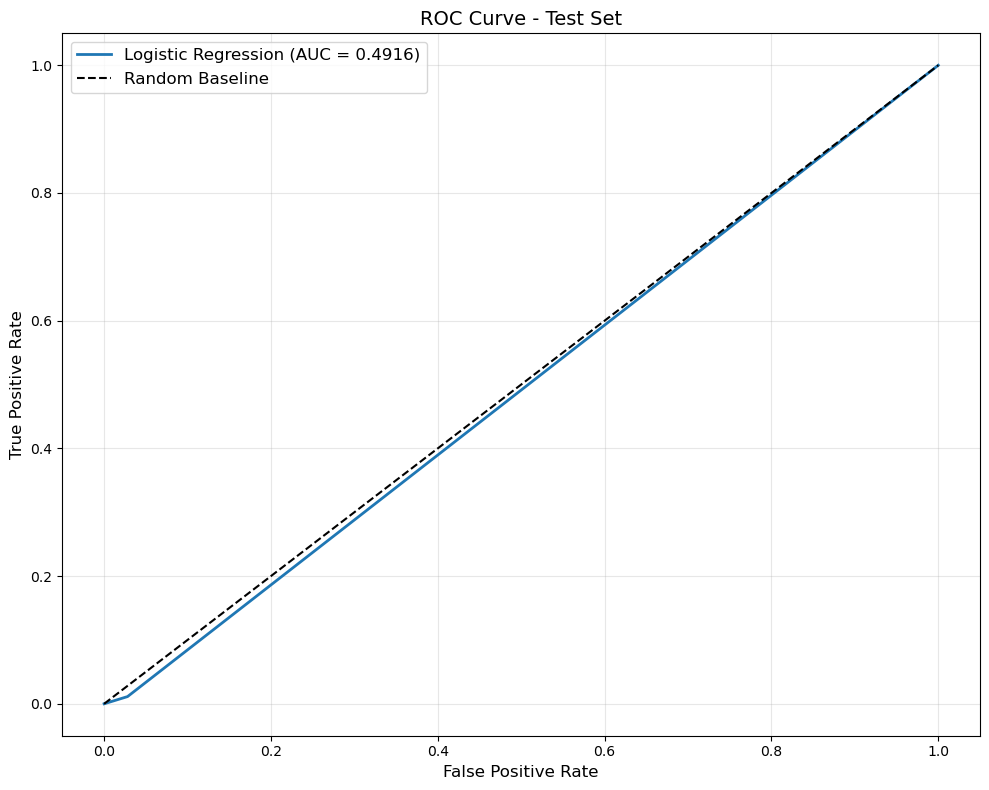

In [48]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

fpr, tpr, thresholds = roc_curve(eval_labels, eval_preds)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'Logistic Regression (AUC = {roc_auc_score(eval_labels, eval_preds):.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Test Set', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()